In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.6 MB/s eta 0:00:00


In [37]:
!pip install -U imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.5 MB/s eta 0:00:00


In [74]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.2 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
df = pd.read_csv("/content/drive/MyDrive/heart_attack_prediction_dataset.csv")


In [41]:
print(df.head())       # Display first few rows
print(df.shape)       # Show dataset dimensions (rows, columns)
print(df.info())      # Show column data types and missing values
print(df.describe())  # Summary statistics


  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  

In [42]:
correlation_matrix = df.corr(numeric_only=True)


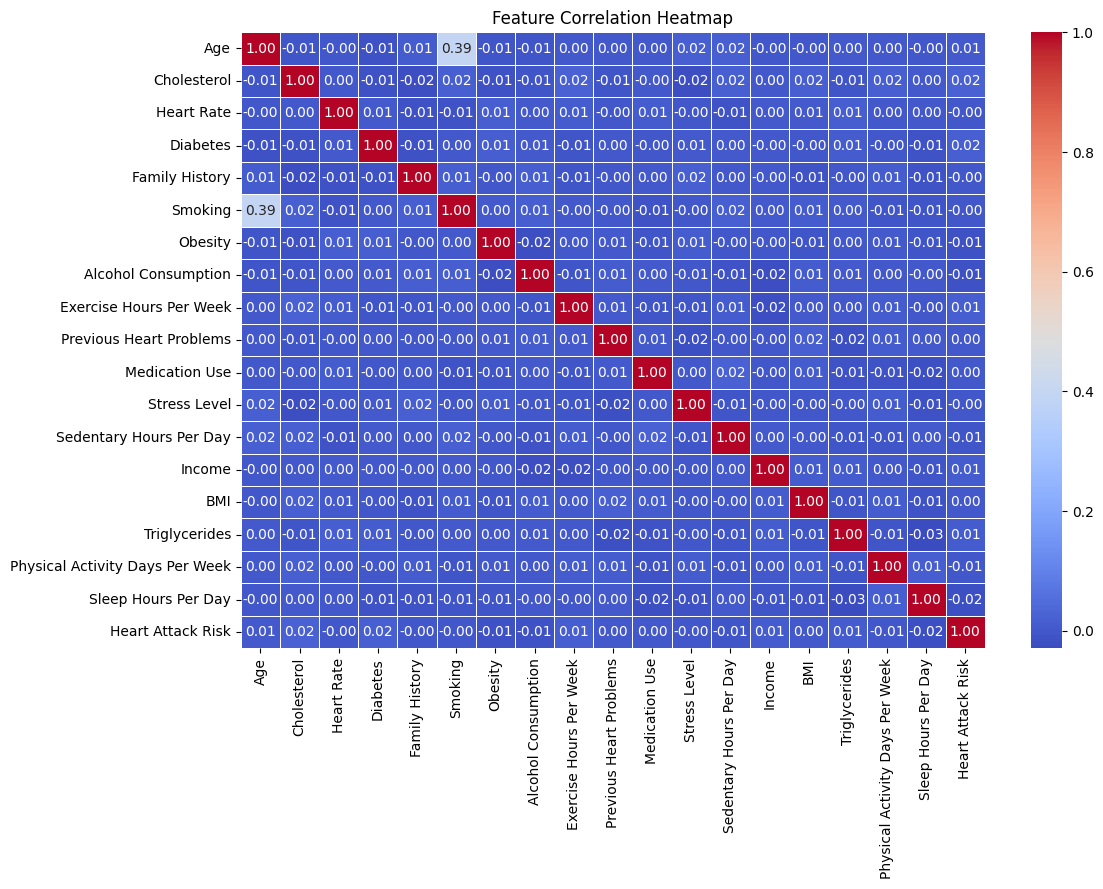

In [43]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [44]:
print(df.columns)


Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')


In [45]:
# Set target variable (replace 'target' with actual column name)
target_var = "Heart Attack Risk"  # Update this with your actual target column name

# Sort features by correlation with target
correlation_with_target = correlation_matrix[target_var].sort_values(ascending=False)
print("\nFeature Correlation with Target:\n", correlation_with_target)




Feature Correlation with Target:
 Heart Attack Risk                  1.000000
Cholesterol                        0.019340
Diabetes                           0.017225
Exercise Hours Per Week            0.011133
Triglycerides                      0.010471
Income                             0.009628
Age                                0.006403
Medication Use                     0.002234
Previous Heart Problems            0.000274
BMI                                0.000020
Family History                    -0.001652
Smoking                           -0.004051
Stress Level                      -0.004111
Heart Rate                        -0.004251
Physical Activity Days Per Week   -0.005014
Sedentary Hours Per Day           -0.005613
Obesity                           -0.013318
Alcohol Consumption               -0.013778
Sleep Hours Per Day               -0.018528
Name: Heart Attack Risk, dtype: float64


In [46]:
# Set correlation threshold (e.g., 0.8 means highly correlated)
corr_threshold = 0.8

# Find pairs of features with high correlation
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print("\nHighly Correlated Features (Consider Removing):", high_corr_features)



Highly Correlated Features (Consider Removing): set()


In [47]:
# Check for missing values
print(df.isnull().sum())

# Fill only numerical missing values with median
df.fillna(df.select_dtypes(include=['number']).median(), inplace=True)

# Fill categorical missing values with mode
df.fillna(df.mode().iloc[0], inplace=True)


Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64


In [48]:
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df.drop(columns=['Blood Pressure'], inplace=True)  # Drop the original column


In [49]:
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])  # Male=1, Female=0
df['Diet'] = label_encoder.fit_transform(df['Diet'])  # Converts categories into numbers


In [50]:
scaler = StandardScaler()
numerical_cols = ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week',
                  'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
                  'Physical Activity Days Per Week', 'Sleep Hours Per Day',
                  'Systolic_BP', 'Diastolic_BP']

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [51]:
print(df.dtypes)  # Ensure all columns are numeric

Patient ID                          object
Age                                float64
Sex                                  int64
Cholesterol                        float64
Heart Rate                         float64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                                 int64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                             float64
BMI                                float64
Triglycerides                      float64
Physical Activity Days Per Week    float64
Sleep Hours Per Day                float64
Country                             object
Continent                           object
Hemisphere 

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Keep only numerical features (exclude target and non-numeric columns)
features = df.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere', 'Heart Attack Risk'])

# Ensure no NaN values
features = features.fillna(features.mean())

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print("\nVariance Inflation Factor (VIF) Scores:\n", vif_data)




Variance Inflation Factor (VIF) Scores:
                             Feature        VIF
0                               Age   1.165183
1                               Sex   4.744332
2                       Cholesterol   1.003474
3                        Heart Rate   1.001666
4                          Diabetes   2.665451
5                    Family History   1.907338
6                           Smoking  11.039754
7                           Obesity   1.928924
8               Alcohol Consumption   2.352772
9           Exercise Hours Per Week   1.001651
10                             Diet   2.330236
11          Previous Heart Problems   1.899162
12                   Medication Use   1.907844
13                     Stress Level   3.938232
14          Sedentary Hours Per Day   1.001831
15                           Income   1.001589
16                              BMI   1.001390
17                    Triglycerides   1.002304
18  Physical Activity Days Per Week   1.001599
19              Sl

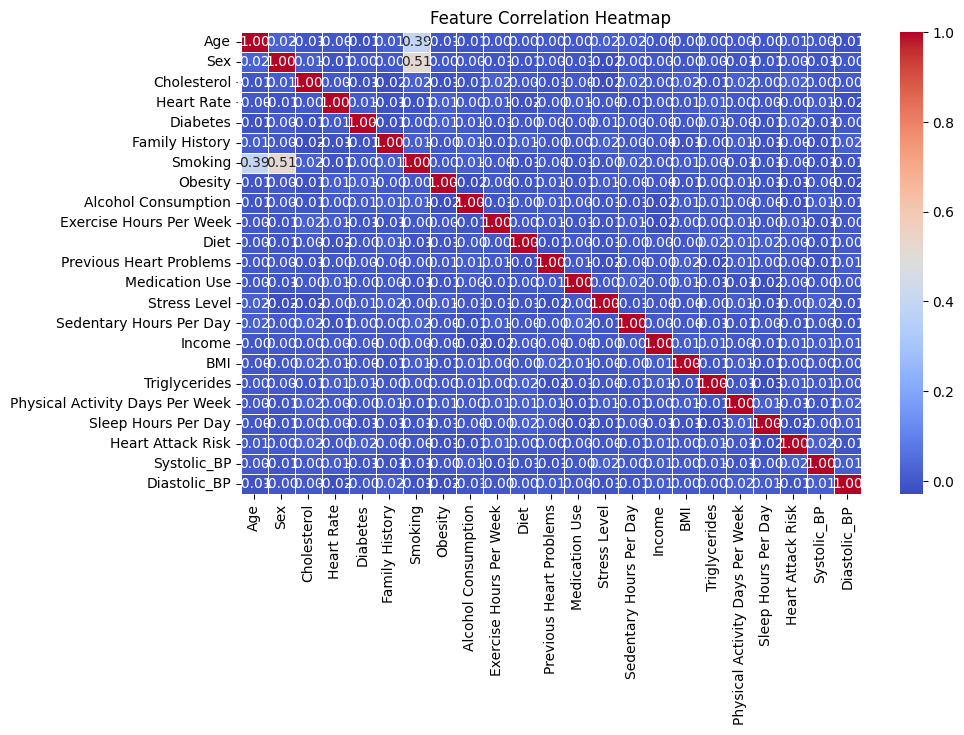

In [53]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Visualize heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64


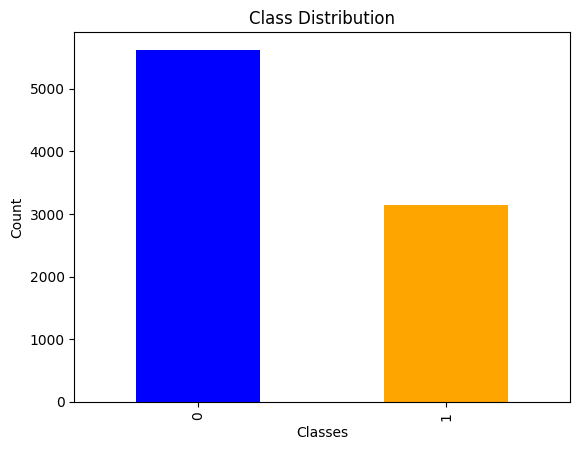

In [54]:
import matplotlib.pyplot as plt

# Check class distribution
print(df['Heart Attack Risk'].value_counts())

# Plot class distribution
df['Heart Attack Risk'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [56]:
print(X.dtypes)


Patient ID                          object
Age                                float64
Sex                                  int64
Cholesterol                        float64
Heart Rate                         float64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                                 int64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                             float64
BMI                                float64
Triglycerides                      float64
Physical Activity Days Per Week    float64
Sleep Hours Per Day                float64
Country                             object
Continent                           object
Hemisphere 

In [57]:
print(X.applymap(lambda x: isinstance(x, str)).sum())


Patient ID                         8763
Age                                   0
Sex                                   0
Cholesterol                           0
Heart Rate                            0
Diabetes                              0
Family History                        0
Smoking                               0
Obesity                               0
Alcohol Consumption                   0
Exercise Hours Per Week               0
Diet                                  0
Previous Heart Problems               0
Medication Use                        0
Stress Level                          0
Sedentary Hours Per Day               0
Income                                0
BMI                                   0
Triglycerides                         0
Physical Activity Days Per Week       0
Sleep Hours Per Day                   0
Country                            8763
Continent                          8763
Hemisphere                         8763
Systolic_BP                           0


<ipython-input-57-a345a9b8f6ef>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(X.applymap(lambda x: isinstance(x, str)).sum())


In [58]:
X = X.drop(columns=['Patient ID'])  # Drop if not relevant for prediction


In [62]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X['Country'] = encoder.fit_transform(X['Country'])
X['Continent'] = encoder.fit_transform(X['Continent'])
X['Hemisphere'] = encoder.fit_transform(X['Hemisphere'])



In [64]:
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['Patient ID'], dtype='object')


In [66]:
# Drop Patient ID
X = X.drop(columns=['Patient ID'])

# Reapply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("SMOTE applied successfully!")


SMOTE applied successfully!


In [68]:
print("Original dataset shape:", X.shape, y.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)


Original dataset shape: (8763, 25) (8763,)
Resampled dataset shape: (11248, 25) (11248,)


<ipython-input-69-dfb1acae9e24>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), ax=ax[0], palette='coolwarm')
<ipython-input-69-dfb1acae9e24>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), ax=ax[1], palette='coolwarm')


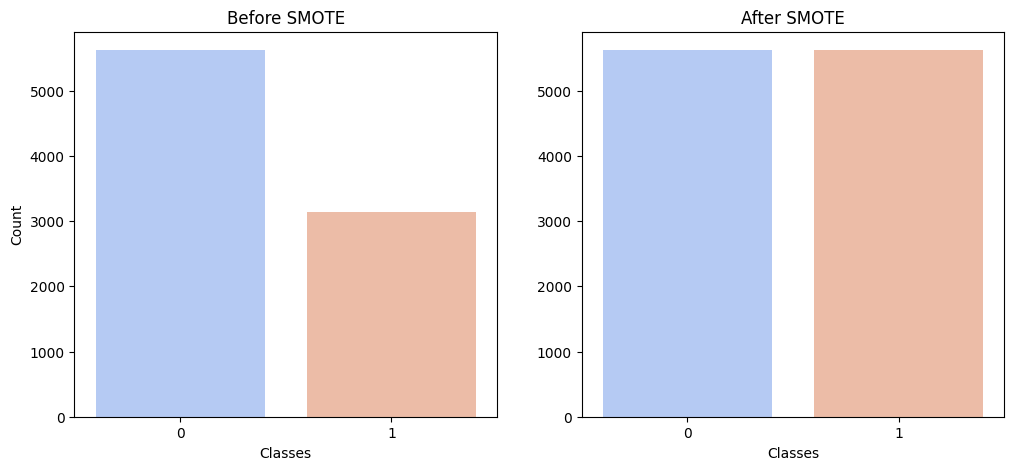

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Original class distribution
original_counts = collections.Counter(y)
resampled_counts = collections.Counter(y_resampled)

# Plot class distribution before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), ax=ax[0], palette='coolwarm')
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("Classes")
ax[0].set_ylabel("Count")

# After SMOTE
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), ax=ax[1], palette='coolwarm')
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Classes")

plt.show()


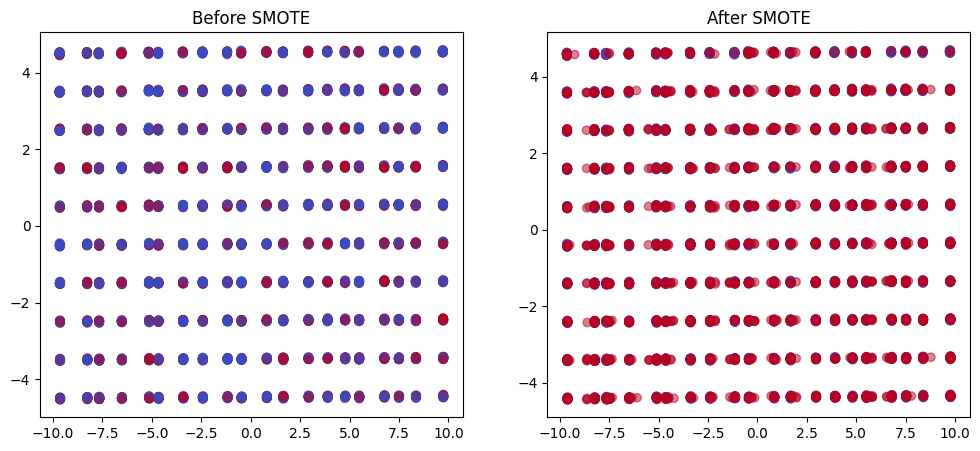

In [70]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca_original = pca.fit_transform(X)
X_pca_resampled = pca.fit_transform(X_resampled)

# Scatter plot of original vs SMOTE-applied data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
ax[0].scatter(X_pca_original[:, 0], X_pca_original[:, 1], c=y, cmap='coolwarm', alpha=0.5)
ax[0].set_title("Before SMOTE")

# After SMOTE
ax[1].scatter(X_pca_resampled[:, 0], X_pca_resampled[:, 1], c=y_resampled, cmap='coolwarm', alpha=0.5)
ax[1].set_title("After SMOTE")

plt.show()


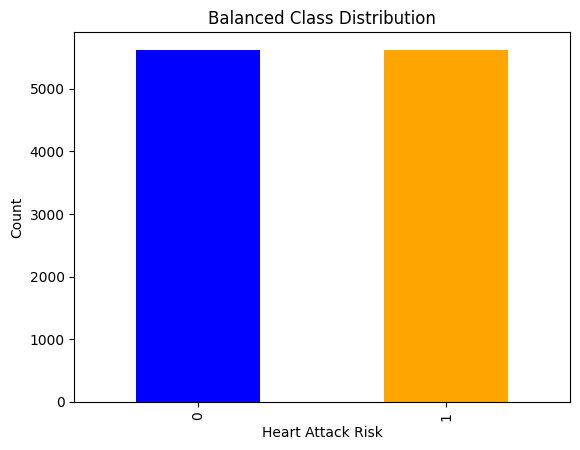

In [71]:
import matplotlib.pyplot as plt

# Check new class distribution
y_resampled.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Heart Attack Risk')
plt.ylabel('Count')
plt.title('Balanced Class Distribution')
plt.show()


In [72]:
from sklearn.model_selection import train_test_split

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Verify class distribution in training and test sets
from collections import Counter
print("Training set class distribution:", Counter(y_train))
print("Testing set class distribution:", Counter(y_test))


Training set class distribution: Counter({0: 4499, 1: 4499})
Testing set class distribution: Counter({1: 1125, 0: 1125})


In [75]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier



In [77]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric="logloss")

}

# Train all models
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"✅ Trained: {name}")


✅ Trained: Logistic Regression
✅ Trained: SVC
✅ Trained: Decision Tree
✅ Trained: Random Forest
✅ Trained: KNN
✅ Trained: Naive Bayes
✅ Trained: XGBoost


In [78]:
def evaluate_model(y_test, y_pred, y_pred_proba, model_name):
    print(f"\n📌 Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    if y_pred_proba is not None:
        print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Loop through models and evaluate
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    evaluate_model(y_test, y_pred, y_pred_proba, name)



📌 Model: Logistic Regression
Accuracy: 0.5995555555555555
Precision: 0.5991150442477876
Recall: 0.6017777777777777
F1 Score: 0.6004434589800444
AUC-ROC: 0.6394121481481481
Confusion Matrix:
 [[672 453]
 [448 677]]

📌 Model: SVC
Accuracy: 0.62
Precision: 0.6278409090909091
Recall: 0.5893333333333334
F1 Score: 0.6079779917469051
AUC-ROC: 0.6608821728395062
Confusion Matrix:
 [[732 393]
 [462 663]]

📌 Model: Decision Tree
Accuracy: 0.5853333333333334
Precision: 0.5823327615780446
Recall: 0.6035555555555555
F1 Score: 0.5927542557835006
AUC-ROC: 0.5853333333333333
Confusion Matrix:
 [[638 487]
 [446 679]]

📌 Model: Random Forest
Accuracy: 0.7084444444444444
Precision: 0.7450365726227796
Recall: 0.6337777777777778
F1 Score: 0.6849183477425552
AUC-ROC: 0.7633362962962963
Confusion Matrix:
 [[881 244]
 [412 713]]

📌 Model: KNN
Accuracy: 0.6311111111111111
Precision: 0.5972313777191826
Recall: 0.8053333333333333
F1 Score: 0.6858440575321726
AUC-ROC: 0.7079885432098765
Confusion Matrix:
 [[514 

Hyperparameter tuning

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grids
rf_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform Randomized Search
rf_search = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
xgb_search = RandomizedSearchCV(XGBClassifier(eval_metric="logloss"), xgb_params, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit models
rf_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

# Get best models
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

print("✅ Best Random Forest:", rf_search.best_params_)
print("✅ Best XGBoost:", xgb_search.best_params_)



✅ Best Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
✅ Best XGBoost: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [80]:
# Retrain with best parameters
best_rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=False, random_state=42)
best_xgb = XGBClassifier(subsample=0.9, n_estimators=300, max_depth=9, learning_rate=0.1, colsample_bytree=0.9, eval_metric="logloss", random_state=42)

best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

print("✅ Retrained Random Forest and XGBoost with optimized parameters.")



✅ Retrained Random Forest and XGBoost with optimized parameters.


In [81]:
# Evaluate the optimized models
print("\n📌 Optimized Random Forest:")
evaluate_model(y_test, best_rf.predict(X_test), best_rf.predict_proba(X_test)[:, 1], "Optimized Random Forest")

print("\n📌 Optimized XGBoost:")
evaluate_model(y_test, best_xgb.predict(X_test), best_xgb.predict_proba(X_test)[:, 1], "Optimized XGBoost")



📌 Optimized Random Forest:

📌 Model: Optimized Random Forest
Accuracy: 0.7213333333333334
Precision: 0.7677419354838709
Recall: 0.6346666666666667
F1 Score: 0.6948905109489051
AUC-ROC: 0.7672948148148148
Confusion Matrix:
 [[909 216]
 [411 714]]

📌 Optimized XGBoost:

📌 Model: Optimized XGBoost
Accuracy: 0.716
Precision: 0.7624190064794817
Recall: 0.6275555555555555
F1 Score: 0.6884446611409069
AUC-ROC: 0.7722959012345678
Confusion Matrix:
 [[905 220]
 [419 706]]


Cross validation for stability

In [85]:
from sklearn.model_selection import cross_val_score

# Define cross-validation folds
cv_folds = 5  # Use 5 or 10 for stability

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv_folds, scoring='roc_auc')
print(f"📌 Random Forest AUC-ROC (CV): {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv_folds, scoring='roc_auc')
print(f"📌 XGBoost AUC-ROC (CV): {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")


📌 Random Forest AUC-ROC (CV): 0.7386 ± 0.0059
📌 XGBoost AUC-ROC (CV): 0.7505 ± 0.0073


In [87]:
from sklearn.model_selection import cross_val_score

# Define cross-validation folds
cv_folds = 10  # Use 5 or 10 for stability

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv_folds, scoring='roc_auc')
print(f"📌 Random Forest AUC-ROC (CV): {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv_folds, scoring='roc_auc')
print(f"📌 XGBoost AUC-ROC (CV): {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")


📌 Random Forest AUC-ROC (CV): 0.7527 ± 0.0151
📌 XGBoost AUC-ROC (CV): 0.7512 ± 0.0210


Feature importance analysis

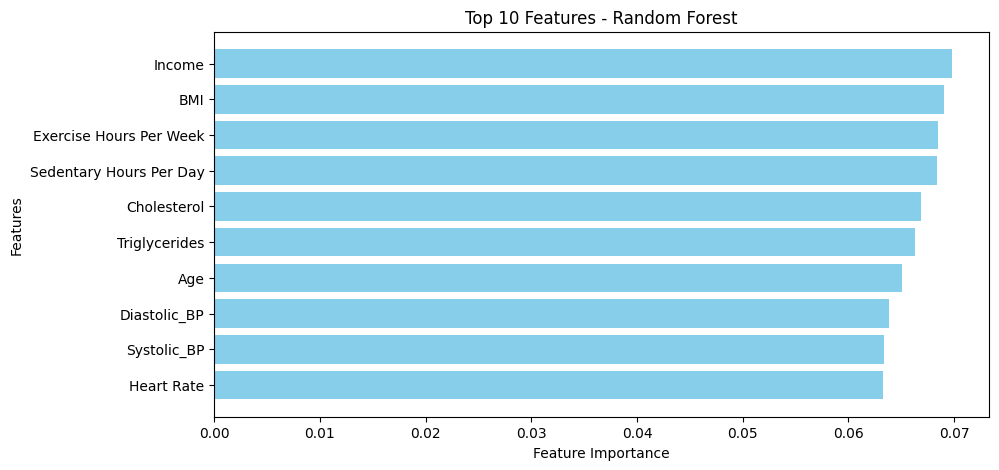

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
rf_importances = best_rf.feature_importances_
xgb_importances = best_xgb.feature_importances_

# Sort feature importance
sorted_indices = np.argsort(rf_importances)[::-1]
features = X_train.columns[sorted_indices]

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 5))
plt.barh(features[:10], rf_importances[sorted_indices][:10], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Features - Random Forest")
plt.gca().invert_yaxis()
plt.show()


In [84]:
for feature, importance in zip(X_train.columns, best_rf.feature_importances_):
    print(f"{feature}: {importance:.5f}")

Age: 0.06507
Sex: 0.00989
Cholesterol: 0.06682
Heart Rate: 0.06323
Diabetes: 0.01038
Family History: 0.01319
Smoking: 0.00525
Obesity: 0.01454
Alcohol Consumption: 0.01059
Exercise Hours Per Week: 0.06844
Diet: 0.01964
Previous Heart Problems: 0.01149
Medication Use: 0.01203
Stress Level: 0.04015
Sedentary Hours Per Day: 0.06839
Income: 0.06981
BMI: 0.06904
Triglycerides: 0.06629
Physical Activity Days Per Week: 0.05013
Sleep Hours Per Day: 0.05754
Country: 0.04582
Continent: 0.02574
Hemisphere: 0.00932
Systolic_BP: 0.06335
Diastolic_BP: 0.06387


Ensemble Learning Voting Classifier

In [88]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

# Define the Voting Classifier (Soft Voting for Probability Averaging)
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    voting='soft'  # Soft voting averages probability predictions
)

# Train on training data
voting_clf.fit(X_train, y_train)

# Predict probabilities for ROC-AUC calculation
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

# Evaluate performance
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"📌 Voting Classifier AUC-ROC: {auc_roc:.4f}")


📌 Voting Classifier AUC-ROC: 0.7814


In [ ]:
import joblib

# Save the trained voting classifier model
joblib.dump(voting_clf, "`heart_attack_risk_model.pkl")

print("✅ Model saved successfully as 'heart_attack_risk_model.pkl'")


✅ Model saved successfully as 'heart_attack_risk_model.pkl'


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict on test data
y_test_pred = voting_clf.predict(X_test)
y_test_pred_proba = voting_clf.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC

# Evaluate model performance
print("\n📌 Model: Voting Classifier (Test Set)")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



📌 Model: Voting Classifier (Test Set)
Accuracy: 0.7253333333333334
Precision: 0.7705442902881536
Recall: 0.6417777777777778
F1 Score: 0.7002909796314258
AUC-ROC: 0.7813562469135802
Confusion Matrix:
 [[910 215]
 [403 722]]


Threshold Optimization

🔹 Best Threshold for Maximum F1 Score: 0.4512
✅ Updated Model Performance:
F1 Score: 0.7057
AUC-ROC: 0.7814
Confusion Matrix:
[[834 291]
 [353 772]]


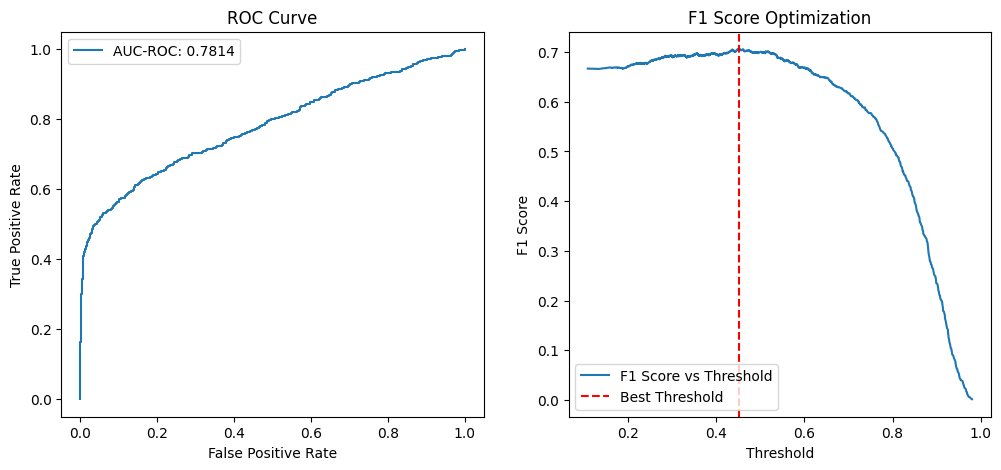

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, auc, confusion_matrix

# Step 1: Get predicted probabilities
y_probs = voting_clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Step 2: Compute Precision-Recall and ROC Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)

# Step 3: Compute F1 scores (slice to match thresholds_pr)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero
best_threshold = thresholds_pr[np.argmax(f1_scores[:-1])]  # Match dimensions

print(f"🔹 Best Threshold for Maximum F1 Score: {best_threshold:.4f}")

# Step 4: Apply New Threshold
y_pred_new = (y_probs >= best_threshold).astype(int)

# Step 5: Recalculate Performance Metrics
new_f1 = f1_score(y_test, y_pred_new)
new_auc_roc = auc(fpr, tpr)
new_conf_matrix = confusion_matrix(y_test, y_pred_new)

print(f"✅ Updated Model Performance:")
print(f"F1 Score: {new_f1:.4f}")
print(f"AUC-ROC: {new_auc_roc:.4f}")
print(f"Confusion Matrix:\n{new_conf_matrix}")

# Step 6: Plot ROC & Precision-Recall Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC-ROC: {new_auc_roc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score vs Threshold")  # Fix applied
plt.axvline(best_threshold, color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score Optimization")
plt.legend()

plt.show()


Stacking model(Ensemble)

In [93]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

# Define meta-classifier (XGBoost or Logistic Regression)
meta_classifier = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=5, passthrough=False)

# Train the stacking model
stacking_clf.fit(X_train, y_train)

# Predict on test set
y_pred = stacking_clf.predict(X_test)
y_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"📌 Stacking Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:38:24] WARNING: /w

📌 Stacking Model Performance:
Accuracy: 0.7178
Precision: 0.8141
Recall: 0.5644
F1 Score: 0.6667
AUC-ROC: 0.7472
Confusion Matrix:
[[980 145]
 [490 635]]
